## Install Essential Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## GET DATA

In [2]:
from sklearn.datasets import fetch_lfw_pairs
lfw_pairs_train = fetch_lfw_pairs(subset="train")
lfw_pairs_test = fetch_lfw_pairs(subset="test")
lfw_pairs_val = fetch_lfw_pairs(subset="10_folds")
list(lfw_pairs_train.target_names)

['Different persons', 'Same person']

In [3]:
y_train = (lfw_pairs_train.target).astype("float32")
y_test = (lfw_pairs_test.target).astype("float32")
y_val = (lfw_pairs_val.target).astype("float32")

In [4]:
print(y_train[:10])
print(y_test[:10])
print(y_val[:10])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [5]:
X_train = lfw_pairs_train.data
X_test = lfw_pairs_test.data
X_val = lfw_pairs_val.data

In [6]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)

In [7]:
print(y_train[:10])
print(y_test[:10])
print(y_val[:10])

[0. 0. 0. 1. 1. 1. 1. 1. 0. 1.]
[0. 0. 1. 0. 0. 0. 1. 1. 1. 0.]
[1. 1. 1. 0. 1. 1. 0. 0. 0. 1.]


Images dimensions are $62*47$ in grayscale. Each train data has pair of images so the shape of train data must be $62 * 47 * 2 = 5828$

In [8]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(2200, 5828)
(1000, 5828)
(6000, 5828)
(2200,)
(1000,)
(6000,)


### Make Pair of Image

We should separate the pair of images.

In [9]:
first_image_train = []
second_image_train = []
for img in X_train:
  first_image_train.append(img[:62*47].reshape(62,47))
  second_image_train.append(img[62*47:].reshape(62,47))

for img in X_val[:5000]:
  first_image_train.append(img[:62*47].reshape(62,47))
  second_image_train.append(img[62*47:].reshape(62,47))


first_image_test = []
second_image_test = []
for img in X_test:
  first_image_test.append(img[:62*47].reshape(62,47))
  second_image_test.append(img[62*47:].reshape(62,47))


first_image_val = []
second_image_val = []
for img in X_val[5000:]:
  first_image_val.append(img[:62*47].reshape(62,47))
  second_image_val.append(img[62*47:].reshape(62,47))

first_image_train = np.array(first_image_train)
second_image_train = np.array(second_image_train)

first_image_test = np.array(first_image_test)
second_image_test = np.array(second_image_test)

first_image_val = np.array(first_image_val)
second_image_val = np.array(second_image_val)

In [10]:
y_train = np.concatenate((y_train, y_val[:5000]), axis=None)
y_val = y_val[5000:]

In [11]:
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(7200,)
(1000,)
(1000,)


In [12]:
print(first_image_train.shape)
print(second_image_train.shape)
print(first_image_test.shape)
print(second_image_test.shape)
print(first_image_val.shape)
print(second_image_val.shape)

(7200, 62, 47)
(7200, 62, 47)
(1000, 62, 47)
(1000, 62, 47)
(1000, 62, 47)
(1000, 62, 47)


### Display Dataset

In [13]:
del (lfw_pairs_train, lfw_pairs_test, lfw_pairs_val,
     X_train, X_test, X_val,
     img)

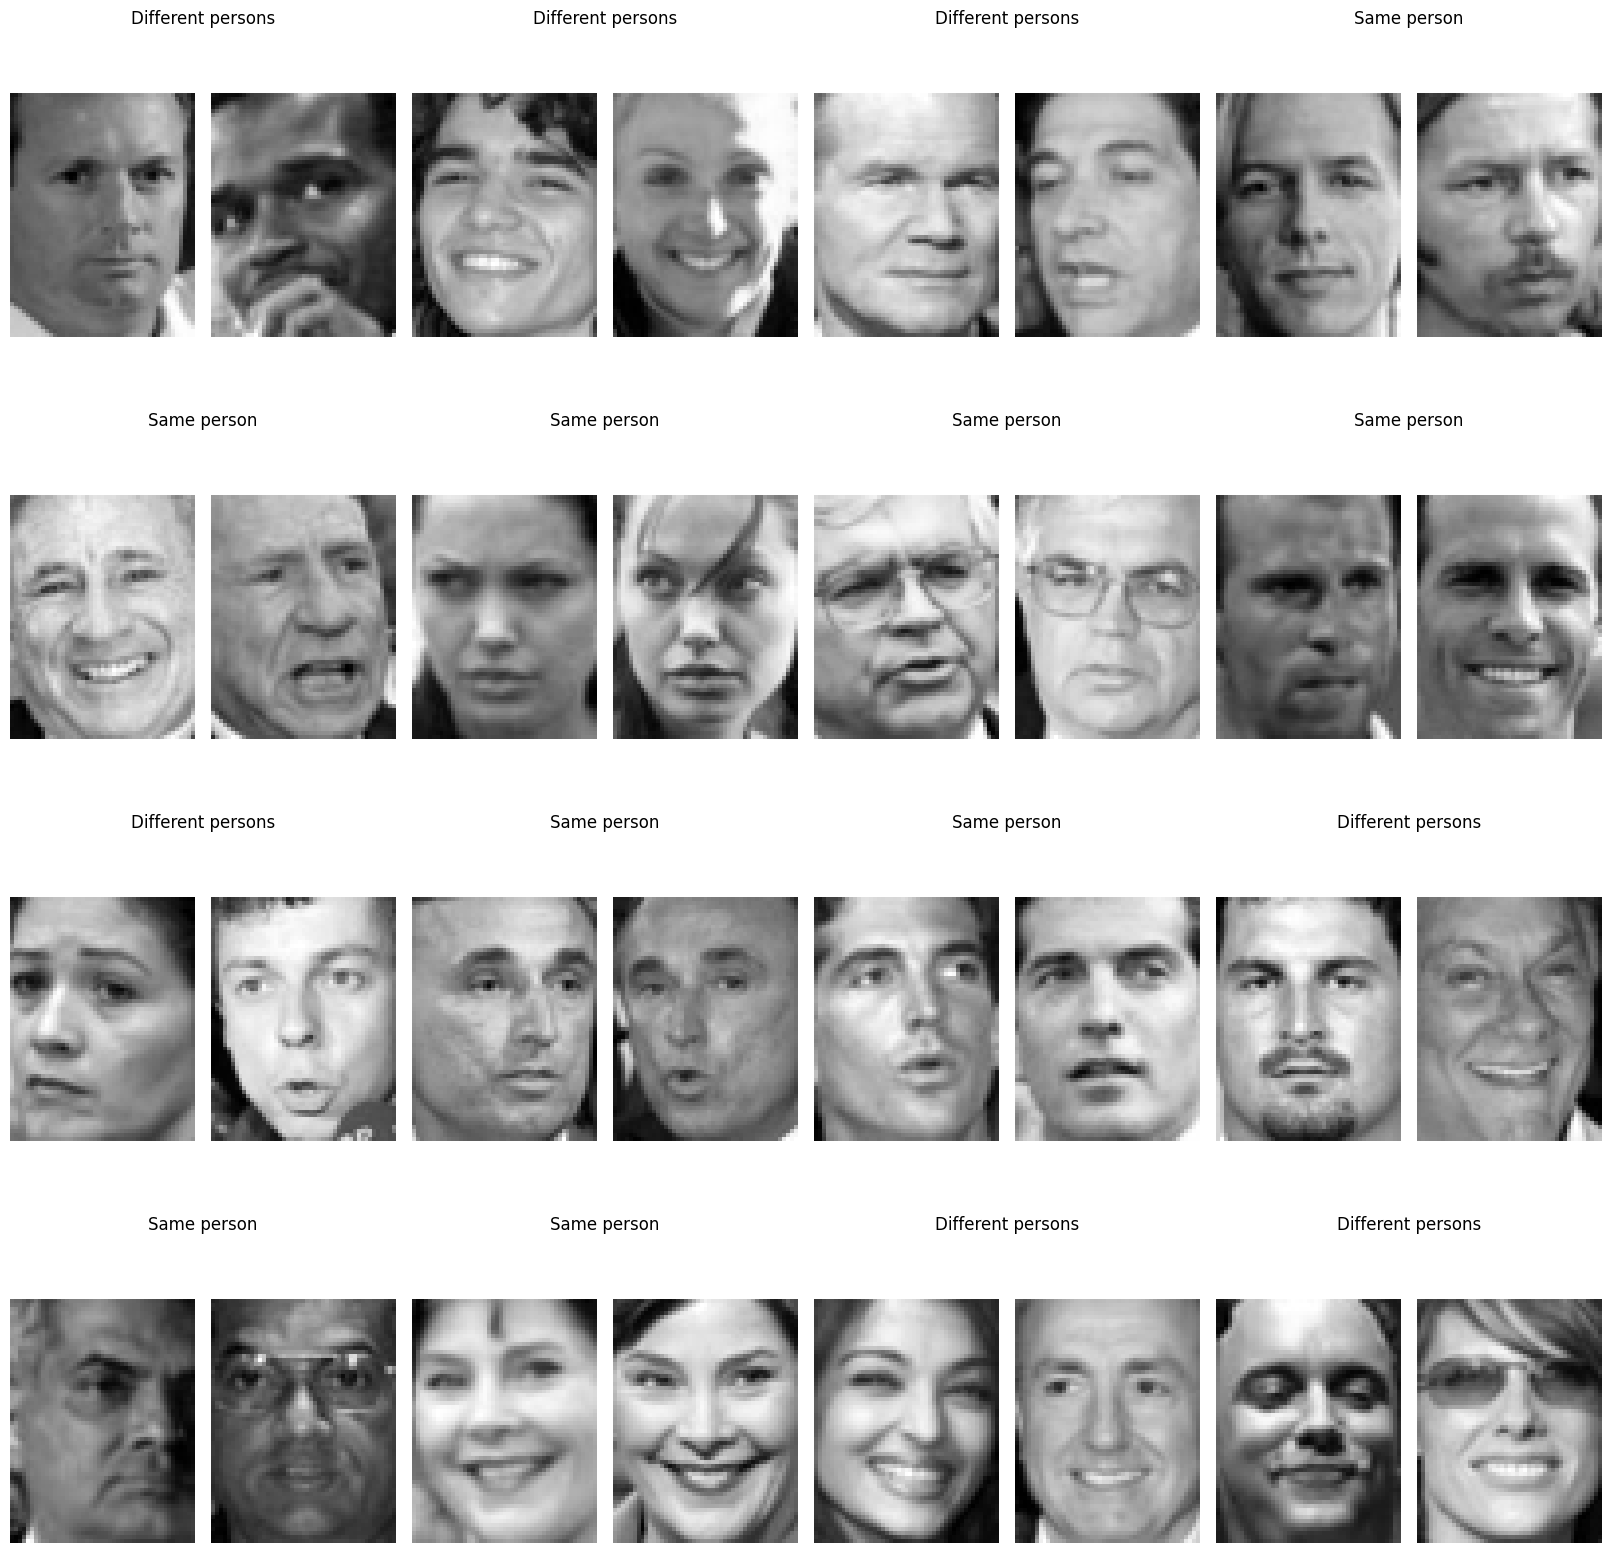

In [14]:
fig = plt.figure(constrained_layout=True, figsize=(16,16))

subfigs = fig.subfigures(4, 4)

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle('Same person'if y_train[outerind] else 'Different persons')
    axs = subfig.subplots(1, 2)

    axs[0].imshow(first_image_train[outerind], cmap='gray')
    axs[0].set_ylabel('First Image')
    axs[0].axis('off')

    axs[1].imshow(second_image_train[outerind], cmap='gray')
    axs[1].set_ylabel('Second Image')
    axs[1].axis('off')

plt.show()

In [15]:
print(first_image_train[0].max())
print(first_image_train[0].min())

0.96732026
0.081045754


### Implement Contrastive Loss

In [16]:
def loss_with_margin(margin = 1):
  def contrastive_loss(y_true, y_pred):
      square_pred = tf.math.square(y_pred)
      margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
      return ((1 - y_true) * square_pred) + (y_true * margin_square)
  return contrastive_loss

### Create Our Siamese Neural Network

In this part we build our neural network:

We have two parallel networks each of them gets one of the images and processes on them. After that, we pass the conclusion of the embedding network to the Euclidean function to calculate the distance between them.
So we have a right model and also a left model.


In [17]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Lambda, Dropout
from keras.models import Model
from keras import backend as K
def siamese_model():

  input_layer = Input(shape=(62, 47, 1))
  cnn = Conv2D(filters=64, kernel_size=(7,7), padding='same', activation='relu')(input_layer)
  cnn = Conv2D(filters=64, kernel_size=(7,7), padding='same', activation='relu')(cnn)
  cnn = MaxPooling2D(pool_size=(2,2))(cnn)

  cnn = Conv2D(filters=128, kernel_size=(5,5), padding='same', activation='relu')(cnn)
  cnn = Conv2D(filters=128, kernel_size=(5,5), padding='same', activation='relu')(cnn)
  cnn = MaxPooling2D(pool_size=(2,2))(cnn)

  cnn = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(cnn)
  cnn = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(cnn)
  cnn = MaxPooling2D(pool_size=(2,2))(cnn)


  cnn = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(cnn)
  cnn = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(cnn)
  cnn = MaxPooling2D(pool_size=(2,2))(cnn)

  fc = Flatten()(cnn)
  out = Dense(units=128, activation='relu')(fc)

  encoder = Model(inputs=input_layer, outputs=out)

  input_a = Input(shape=(62, 47, 1))
  input_b = Input(shape=(62, 47, 1))

  branch_a = encoder(input_a)
  branch_b = encoder(input_b)

  distance = Lambda(lambda x: K.sqrt(K.maximum(K.sum(K.square(x[0] - x[1]), axis=1, keepdims=True), K.epsilon())), output_shape=(None, 1))([branch_a, branch_b])
  siamese_network = Model(inputs=[input_a, input_b], outputs=distance)

  return siamese_network

##### Create a model and display the summary of its.

In [18]:
siamese_model = siamese_model()

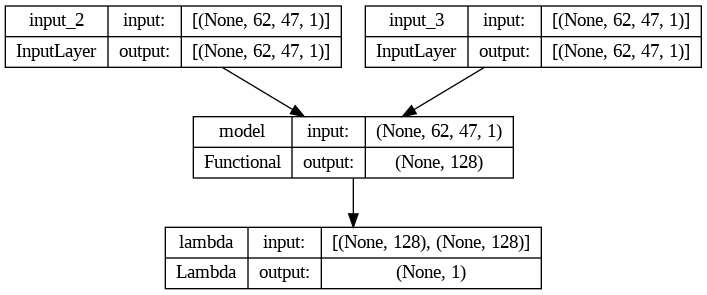

In [19]:
from keras import utils

utils.plot_model(siamese_model, show_shapes=True, show_layer_names=True)

##### Compile Model

In [20]:
from keras.optimizers import Adam

siamese_model.compile(loss=loss_with_margin(), optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])

##### Fit Model

In [21]:
history = siamese_model.fit(
    [first_image_train, second_image_train],
    y_train,
    validation_data=([first_image_val, second_image_val], y_val),
    batch_size=64,
    epochs=50
)

Epoch 1/50
113/113 [==============================] - 55s 344ms/step - loss: 0.3434 - accuracy: 0.4553 - val_loss: 0.3093 - val_accuracy: 0.4590
Epoch 2/50
113/113 [==============================] - 32s 287ms/step - loss: 0.2900 - accuracy: 0.4844 - val_loss: 0.2852 - val_accuracy: 0.4560
Epoch 3/50
113/113 [==============================] - 34s 300ms/step - loss: 0.2755 - accuracy: 0.4958 - val_loss: 0.2804 - val_accuracy: 0.4800
Epoch 4/50
113/113 [==============================] - 35s 314ms/step - loss: 0.2636 - accuracy: 0.5168 - val_loss: 0.2714 - val_accuracy: 0.5030
Epoch 5/50
113/113 [==============================] - 37s 331ms/step - loss: 0.2541 - accuracy: 0.5485 - val_loss: 0.2678 - val_accuracy: 0.5040
Epoch 6/50
113/113 [==============================] - 39s 345ms/step - loss: 0.2461 - accuracy: 0.5739 - val_loss: 0.2634 - val_accuracy: 0.5030
Epoch 7/50
113/113 [==============================] - 41s 364ms/step - loss: 0.2375 - accuracy: 0.6033 - val_loss: 0.2556 - val_ac

In [22]:
siamese_model.save('face_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### Plot Accuracy & Loss

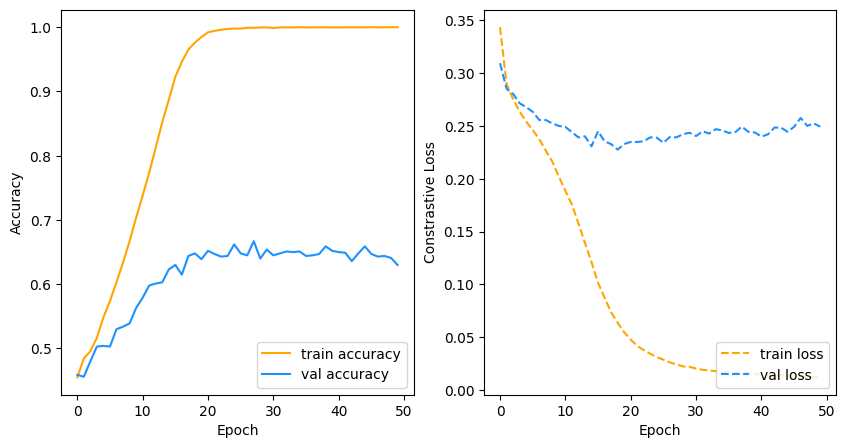

In [23]:
f = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],
         label='train accuracy',
         c='orange', ls='-')
plt.plot(history.history['val_accuracy'],
         label='val accuracy',
         c='dodgerblue', ls='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'],
         label='train loss',
         c='orange', ls='--')
plt.plot(history.history['val_loss'],
         label='val loss',
         c='dodgerblue', ls='--')
plt.xlabel('Epoch')
plt.ylabel('Constrastive Loss')
plt.legend(loc='lower right')
plt.show()

##### Prediction of Test Images

In [24]:
predictions = siamese_model.predict([first_image_test, second_image_test])

32/32 [==============================] - 1s 41ms/step


In [25]:
print(predictions.shape)

(1000, 1)


In [26]:
predictions = (predictions.ravel() >= 0.5)
print(predictions.shape)

(1000,)


#### Display Results

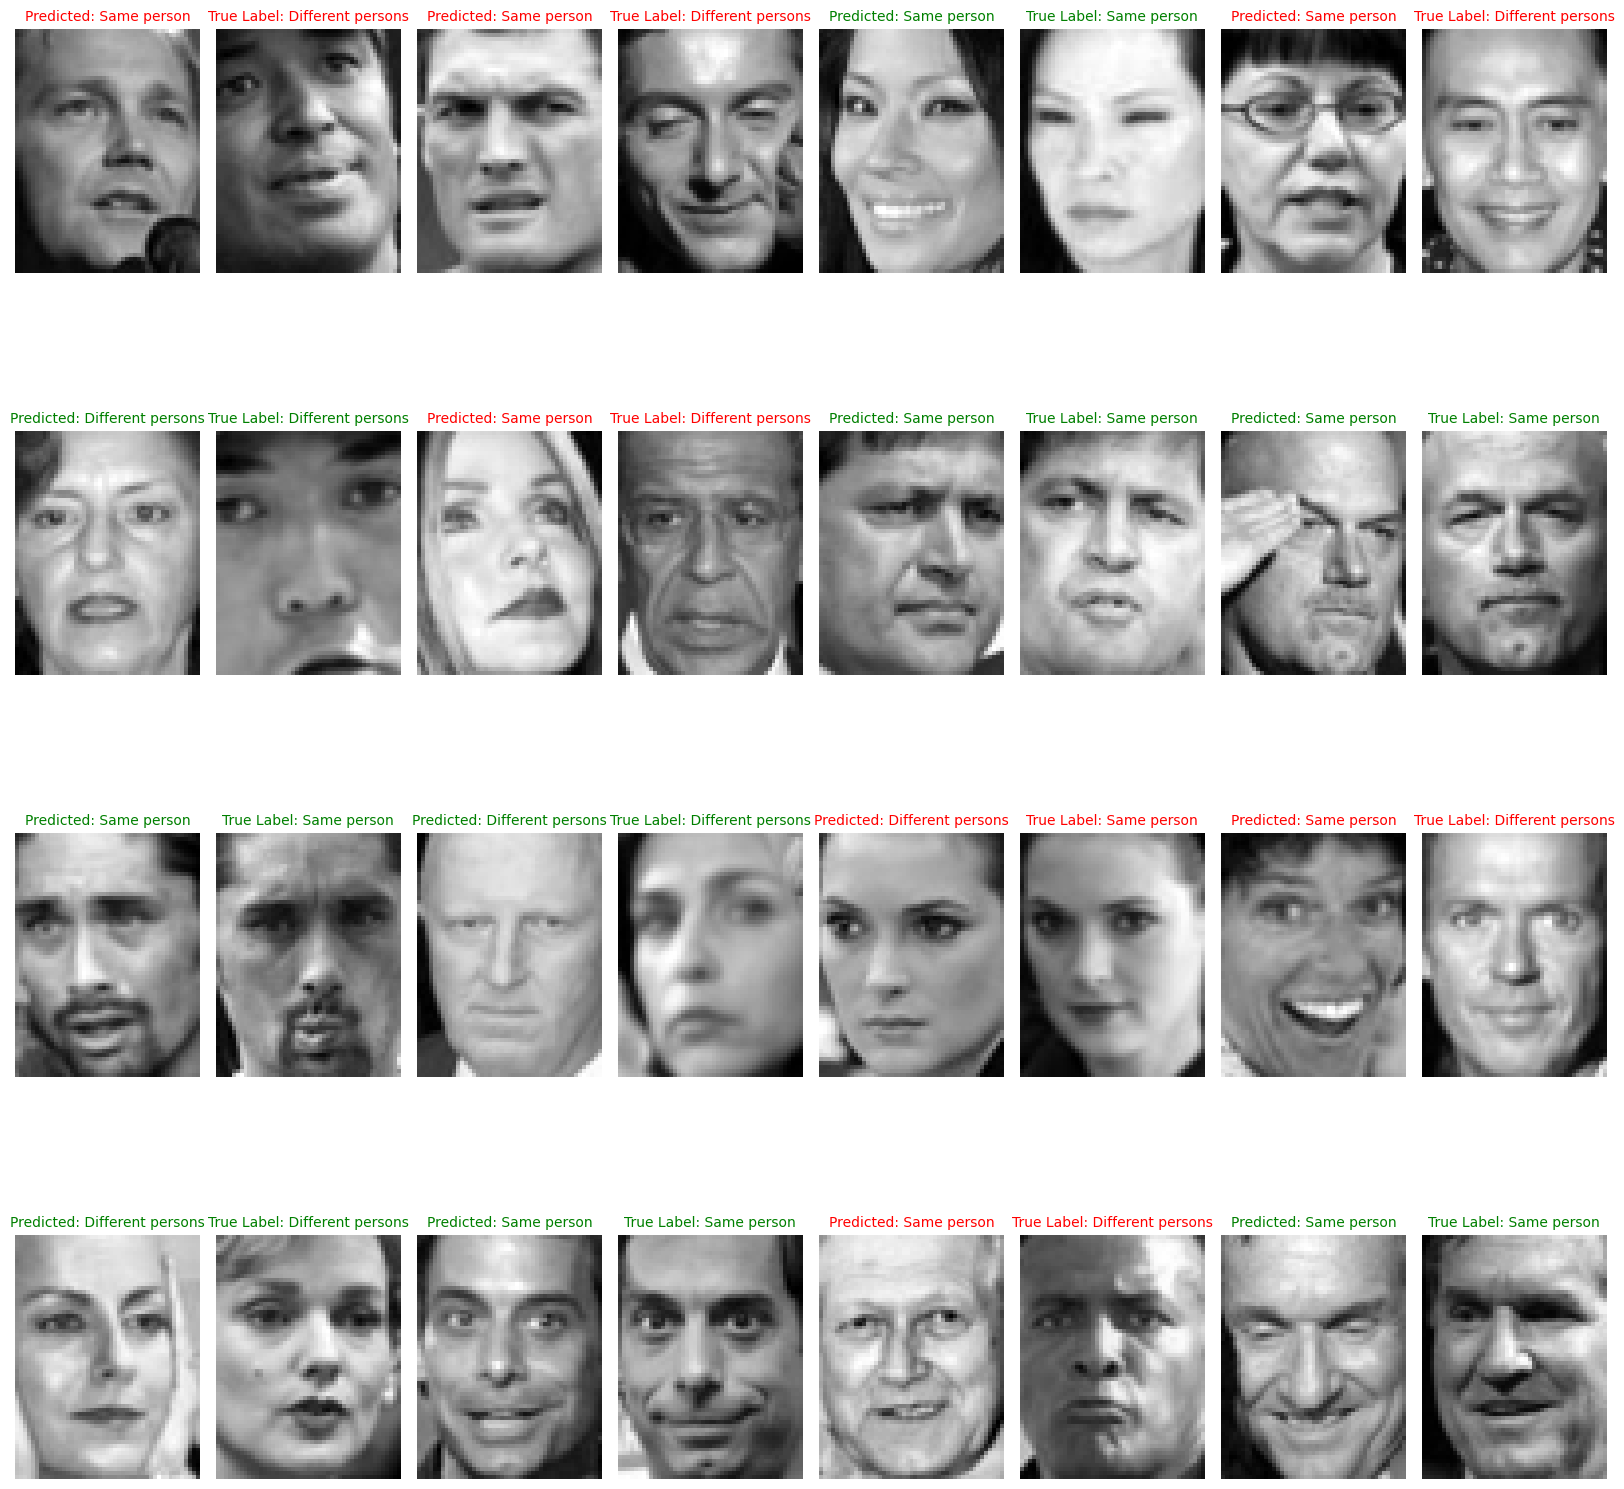

In [27]:
fig = plt.figure(constrained_layout=True, figsize=(16,16))

subfigs = fig.subfigures(4, 4)
for outerind, subfig in enumerate(subfigs.flat):
    # subfig.suptitle('Same person'if y_test[outerind] else 'Different persons', color= 'green', fontweight='bold')
    axs = subfig.subplots(1, 2)

    axs[0].imshow(first_image_test[outerind], cmap='gray')
    axs[0].set_ylabel('First Image')
    axs[0].axis('off')
    axs[0].set_title('Predicted: ' + ('Same person' if predictions[outerind] else 'Different persons'), color='green' if y_test[outerind] == predictions[outerind] else 'red', fontsize=10)

    axs[1].imshow(second_image_test[outerind], cmap='gray')
    axs[1].set_ylabel('Second Image')
    axs[1].axis('off')
    axs[1].set_title('True Label: ' + ('Same person' if y_test[outerind] else 'Different persons'), color='green' if y_test[outerind] == predictions[outerind] else 'red', fontsize=10)

plt.show()

In [28]:
print(f"Test Accuracy: {np.mean(y_test == predictions) * 100}")

Test Accuracy: 66.2
